In [10]:
from sklearn.datasets import fetch_mldata
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV

import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [11]:
# TODO: replace with openml http://scikit-learn.org/stable/auto_examples/neural_networks/plot_mnist_filters.html
mnist = fetch_mldata('MNIST original')
mnist

/home/david/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)
/home/david/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)


{'DESCR': 'mldata.org dataset: mnist-original',
 'COL_NAMES': ['label', 'data'],
 'target': array([0., 0., 0., ..., 9., 9., 9.]),
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

In [12]:
X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


In [13]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off")
    
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

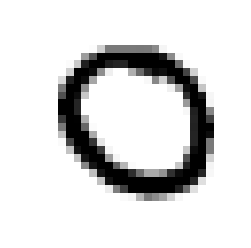

In [14]:
some_digit = X[3000]
plot_digit(some_digit)

In [15]:
# split our data into train & validation sets like good data scientists
TEST_SET_SIZE = 60_000
RANDOM_STATE = 42
X_train, X_test, y_train, y_test = X[:TEST_SET_SIZE], X[TEST_SET_SIZE:], y[:TEST_SET_SIZE], y[TEST_SET_SIZE:]

shuffle_index = np.random.RandomState(RANDOM_STATE).permutation(60_000)


X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [16]:
# let's play with Dask
# Just kidding, I think dask is messing with other function's parallel backends somehow. Let's KISS for now.
# with joblib.parallel_backend("dask", scatter=[X_train, y_train_5]):

# import dask_ml.joblib
# from dask.distributed import Client
# from sklearn.externals import joblib

# if "client" in locals():
#     client.close()
    
# client = Client(diagnostics_port=8786, scheduler_port=8785)
# client

In [17]:
%%time
# Binary classifer: Is it a 5?

# create labels just for 5
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

sgd_clf = SGDClassifier(
    random_state=RANDOM_STATE,
    max_iter=80,
    n_jobs=-1
)

# NOTE: this will only run on one core since we only have one class
# from the docs: "The number of CPUs to use to do the OVA 
# (One Versus All, for multi-class problems) computation."
sgd_clf.fit(X_train, y_train_5)
print(sgd_clf)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=80,
       n_iter=None, n_iter_no_change=5, n_jobs=-1, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)
CPU times: user 5.1 s, sys: 81.4 ms, total: 5.18 s
Wall time: 5.18 s


array([ True])

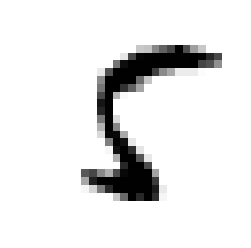

In [18]:
five_idx = np.where(y_train_5 == True)[0][1]
five_digit = X_train[five_idx]
plot_digit(five_digit)
sgd_clf.predict([five_digit])

In [19]:
# Performance Measures

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3,random_state=RANDOM_STATE)

# "manually" doing cross-validation with stratified kfolds
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9589
0.9683
0.9689


In [20]:
from sklearn.model_selection import cross_val_score

# now the easy way
# note this uses stratifiedKFolds under the hood http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html
print(cross_val_score(
    sgd_clf,
    X_train,
    y_train_5,
    cv=3,
    scoring="accuracy",
    n_jobs=-1
))

[0.9589 0.9683 0.9689]


In [22]:
# Making an intentionally bad etimator to show that numbers lie

from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never_5_clf = Never5Classifier()
print(cross_val_score(
    never_5_clf,
    X_train,
    y_train_5,
    cv=3,
    scoring="accuracy",
    n_jobs=-1
))
# we get 90%+ scores because only 10% of our data could possibly be 5s
# ergo accuracy is not a great measure for models

[0.909   0.90715 0.9128 ]


In [23]:
# Confusion Matrix

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3)
print(y_train_pred.shape)

"""
                         Predicted
                    Negative    Positive
        Negative  [[True neg,   False neg],
Actual
        Positive   [False pos,  True pos]]
"""
confusion_matrix(y_train_5, y_train_pred)


(60000,)


array([[53982,   597],
       [ 1481,  3940]])

In [24]:
# Precision and Recall

# Precision
# TP / (TP + FP)
# How many times were we right when we said something was a 5?

# Recall
# TP / (TP + FN)
# Of the 5s that existed, how many did we correctly guess?

# F1 Score
# A score comprised of both precision & accuracy. Is only high when both are high

# Note that depending on our use case, we may prefer to have 
# higher precision (detecting shoplifting) or higher recall (NSFW classifier)

from sklearn.metrics import precision_score, recall_score, f1_score
print(f"Precision: {precision_score(y_train_5, y_train_pred)}")
print(f"Recall: {recall_score(y_train_5, y_train_pred)}")
print(f"F1: {f1_score(y_train_5, y_train_pred)}")


Precision: 0.8684152523694071
Recall: 0.7268031728463383
F1: 0.7913235589475799


In [25]:
# Precision/Recall Tradeoff

# sklearn also gives us the ability to just return the raw output of 
# decision functions, where we can set our own threshold for classification
some_score = sgd_clf.decision_function([five_digit])
print(some_score)
threshold1 = 0
threshold2 = 25_000
print(some_score > threshold1)
print(some_score > threshold2)

[21389.10555428]
[ True]
[False]


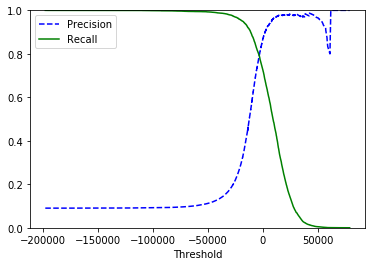

In [27]:
from sklearn.metrics import precision_recall_curve

y_scores = cross_val_predict(
    sgd_clf,
    X_train,
    y_train_5,
    cv=3,
    method="decision_function",
    n_jobs=-1
)
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0,1])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)


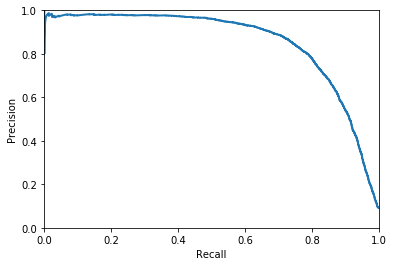

In [28]:
# we can also just plot precision against recall
def plot_precision_recall(precisions, recalls):
    plt.plot(recalls, precisions, linewidth=2, label="Precision")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.axis([0,1,0,1])

plot_precision_recall(precisions, recalls)

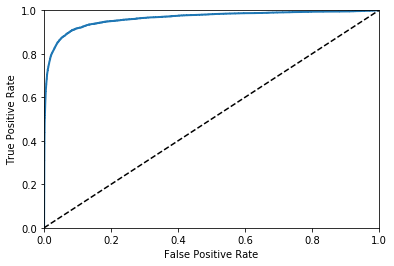

In [29]:
# The ROC Curve
# ROC stands for "receiver operating characteristic"
# which is true positive rate vs false positive rate

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1], "k--")
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr, tpr)

In [30]:
from sklearn.metrics import roc_auc_score

# NOTE: rule of thumb - use PR curve when positive class is rare
# or we care more about false positives than false negatives
# use ROC otherwise

# AUC Score or "Area Under the Curve" score of 1 is a perfect model,
# and an auc of .5 is purely random
roc_auc_score(y_train_5, y_scores)


0.9634048297092467

In [31]:
# now let's get an easy win by using a nonlinear classifier

from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=RANDOM_STATE)
y_probas_forest = cross_val_predict(
    forest_clf,
    X_train,
    y_train_5,
    cv=3,
    method="predict_proba",
    n_jobs=-1
)

Random Forest AUC: 0.9931243366003829


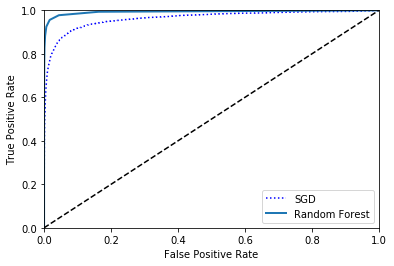

In [32]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")

print(f"Random Forest AUC: {roc_auc_score(y_train_5,y_scores_forest)}")

In [33]:
# Multi-class Classification

# sklearn detects when you're doing single vs multiclass. Easy!
# also now dask works as expected because we're doing one-versus-all (OVA)
# instead of one-versus-one (OVO) (for single class and SVMs)
some_digit_scores = sgd_clf.fit(X_train, y_train) # now doing multiclass

In [34]:
print(sgd_clf.predict([five_digit]))
# notice here the highest score is our chosen class
print(sgd_clf.decision_function([five_digit]))
print(sgd_clf.classes_)

[5.]
[[  1461.83045899 -56128.72166268 -31698.51853516 -44690.55090162
  -50271.28185211  21389.10555428 -38539.16431899 -32033.41280226
    7698.01829581 -33455.90077804]]
[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]


In [35]:
from sklearn.multiclass import OneVsOneClassifier

# here we can force the use of OVO rather than OVA
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=RANDOM_STATE, max_iter=50))
ovo_clf.fit(X_train, y_train)
print(len(ovo_clf.estimators_)) # one binary classifer for each digit versus each other digit
ovo_clf.predict([five_digit])

45


array([5.])

In [36]:
forest_clf.fit(X_train, y_train)
print(forest_clf.predict([five_digit]))
print(forest_clf.predict_proba([five_digit]))


/home/david/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[5.]
[[0.  0.  0.  0.  0.  0.9 0.1 0.  0.  0. ]]


In [37]:
# Now that we've trained our multi-class classifiers, let's see how good they are
from sklearn.preprocessing import StandardScaler

print(cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy", n_jobs=-1))
# this is okay, but we can do better just by scaling inputs
# note that 10% accuracy would be a random guess

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
print(cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy", n_jobs=-1))


[0.86677664 0.87529376 0.86157924]
[0.91361728 0.91309565 0.9099865 ]


[[5697    1   20    9   11   44   45    7   84    5]
 [   1 6472   45   22    6   47    5    9  121   14]
 [  36   32 5364   95   75   27   78   53  186   12]
 [  38   28  135 5359    2  232   29   52  166   90]
 [  15   21   43   11 5341    9   51   30  117  204]
 [  51   34   31  189   60 4603   89   28  245   91]
 [  31   24   48    2   37   95 5603    7   71    0]
 [  22   17   71   30   50   11    6 5782   33  243]
 [  34  107   56  130    6  142   45   14 5228   89]
 [  29   26   32   81  145   34    1  193  123 5285]]


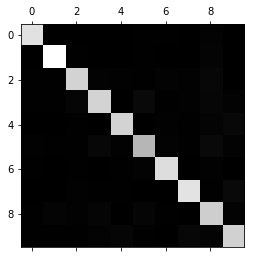

In [39]:
# Error Analysis
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3, n_jobs=-1)
conf_mx = confusion_matrix(y_train, y_train_pred)
print(conf_mx)
plt.matshow(conf_mx, cmap=plt.cm.gray)
# this confusion matrix looks pretty good since most of the bright spots are on the diagonal

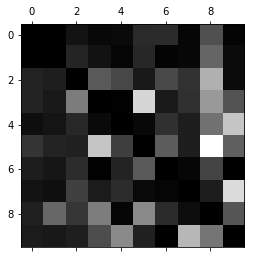

In [40]:
# lets ignore the stuff we got correct and highlight errors
row_sums = conf_mx.sum(axis=1,keepdims=True) # axis 1 is rows, keepdims means don't flatten output array
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
# rememeber that rows are actual classes, cols are predicted classes

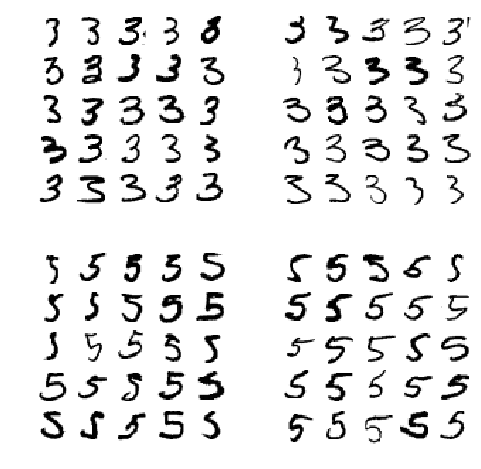

In [41]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

In [42]:
# Multilabel classification
# This is a classifier which outputs a binary vector of all possible classes for each instance

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd] # concat along 2nd axis eg shape ((3,1),(3,1)) => shape (3,2)

# can't seem to parallelize
knn_clf = KNeighborsClassifier(n_jobs=-1)
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform')

In [43]:
# correctly predict that 5 is not >= 7, and is odd!
knn_clf.predict([five_digit])

array([[False,  True]])

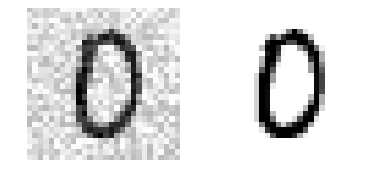

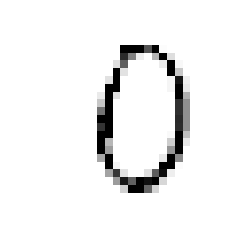

In [44]:
# Multioutput Classification
# Similar to multilabel classification, except instead of the per-instance output vectors 
# being binary, they are multiclass

# In this example we denoise mnist images
# Input is noisy images, output is multiclass (pixel intensities) vector representing the clean image

noise = np.random.randint(0,100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0,100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test
plt.subplot(121); plot_digit(X_test_mod[10])
plt.subplot(122); plot_digit(y_test_mod[10])
plt.show() 

knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[10]])
plot_digit(clean_digit)

In [45]:
# Exercises

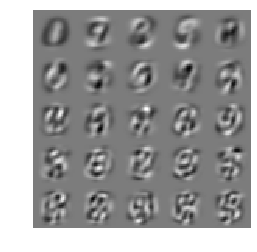

In [36]:
# 1) Build an mnist classifier that is > 97% accurate

from sklearn.decomposition import PCA

n_components = 50
pca = PCA(n_components=n_components).fit(X_train)
X_train_pc = pca.transform(X_train_scaled)
eigenfeatures = pca.components_.reshape((n_components, 28,28))
plot_digits(eigenfeatures[:25], images_per_row=5)

X_test_scaled = scaler.transform(X_test.astype('float64'))
X_test_pc = pca.transform(X_test_scaled)

In [37]:
# Using Random Forest 

param_distributions = {
    "bootstrap": [True, False],
    "n_estimators": [(x * 5 + 3) for x in range(10)],
    "max_features": [(x * 2) for x in range(2, 10)]
}

forest_clf = RandomForestClassifier()
best_forest_clf = RandomizedSearchCV(
    forest_clf,
    param_distributions,
    cv=3,
    n_iter=12,
    n_jobs=-1,
    verbose=3
)
best_forest_clf.fit(X_train_scaled, y_train)
print(best_forest_clf.best_score_)
print(best_forest_clf.best_params_)
best_forest_clf.score(X_test_scaled, y_test)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:   41.3s finished


0.9599166666666666
{'n_estimators': 38, 'max_features': 18, 'bootstrap': True}


0.9648

In [40]:
# Now let's try again with KNN...

params = {
    "weights": ["uniform", "distance"],
    "n_neighbors": list(range(3,10,2)),
}
new_knn_clf = KNeighborsClassifier()
best_knn_clf = RandomizedSearchCV(
    new_knn_clf,
    params,
    cv=3,
    n_iter=7,
    scoring="accuracy",
    n_jobs=-1,
    verbose=3,
)
best_knn_clf.fit(X_train_pc, y_train)
print(best_knn_clf.best_score_)
print(best_knn_clf.best_params_)

Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


0.97465
{'weights': 'distance', 'n_neighbors': 3}


[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed: 16.3min finished


In [42]:
best_knn_clf.predict(pca.transform([five_digit]))

array([5.])

In [43]:
print(best_knn_clf.score(X_test_pc, y_test))


0.973
